In [7]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import tensorflow.keras.layers as tfkl

### regression

Let's start by using `keras` to make a neural network for a simple regression task where both the input and the output as 1-dimensional. Below is some code that will produce the dataset for you to train on.

Here are some general steps to follow:
1. Define your model by passing `tfk.Sequential` a list of layers (found in `tf.keras.layers`, which is already imported for you by the shorter name `tfkl`, since you will use this module many times.
2. Your first layers should be a `tfkl.Input` layer that specifies the shape of the input (it will automatically include an empty first dimension with size `None` as a placehold for the batch size).
3. The rest of your layers should be `tfkl.Dense` layers; you will be to specify the number of neurons/units as well as the activation function (you can find those in `tf.nn`, and you can use `None` for a "linear" activation function, $f(x)=x$). Make sure you pick an output function that makes sense for this prediction task!
4. Choose an appropriate optimizer from `tfk.optimizers` and an appropriate loss function from `tfk.losses` (both are classes that wil need to be initialized), and then pass them to `model.compile` to compile your model.
5. Call `model.fit` to fit your model and collect the results
6. Plot your training curve (loss vs training step)
7. Call your model (`model(...)`) on a grid of inputs (code to make the grid provided) and plot the relationship your model learned against the true relationship (defined as `f` in the code below).

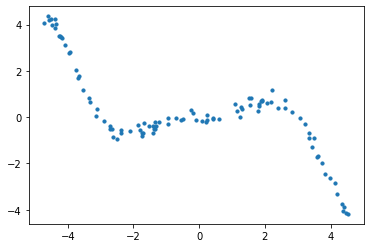

In [9]:
def regression_data(N):
  x = np.random.uniform(low=-5.0, high=5.0, size=(N, 1)).astype(np.float32)
  e = 0.2 * np.random.normal(size=(N, 1)).astype(np.float32)
  f = lambda x: 0.2 * x**2 * np.sin(2 * np.pi * x / 6)
  y = f(x) + e
  return x, y

N = 100
x, y = regression_data(N)

plt.scatter(x, y, s=10)
plt.show()

In [19]:
a = tf.nn.relu
model= tfk.Sequential([
    tfkl.Input((1,)),
    tfkl.Dense(200,activation=a),
    tfkl.Dense(50,activation=a),
    tfkl.Dense(1,activation= None)
    
])

model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001D7EE5E76D8>>

In [24]:
loss= tfk.losses.MeanSquaredError()
opt = tfk.optimizers.Adam()
model.compile(opt,loss)

results=model.fit(x,y,epochs=1000, verbose=0)

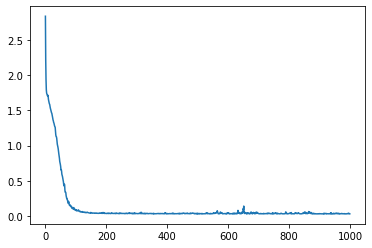

In [23]:
plt.plot(results.history['loss'])

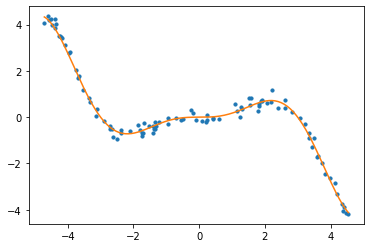

In [26]:
f= lambda x: 0.2 *x**2 * np.sin(2*np.pi * x/6)
x_grid = np.linspace(x.min(), x.max(), 200).astype(np.float32)[:, np.newaxis]
y_true = f(x_grid)
plt.scatter(x,y, s=10)
plt.plot([],[])
plt.plot(x_grid,y_true)
plt.show()

### binary classification

Here is another dataset that differs in two key ways from the regression example we just worked:
1. The input is now 2-dimensional
2. The targets are now binary classes

Update your model to handle both of these changes and try fitting this new data. Think about the following:
- input shape
- output function
- loss function

Since visualizing the results is a bit tricky, we have provided some code for that.

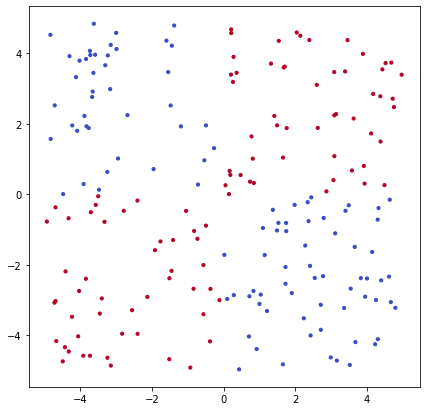

In [27]:
N = 200
def binary_classification_data(N):
  x = np.random.uniform(low=-5, high=5, size=(N, 2))
  y = (x[:, 0] * x[:, 1] > 0).astype(np.int)
  return x, y

x_train, y_train = binary_classification_data(N)
x_test, y_test = binary_classification_data(N)

plt.figure(figsize=(7, 7))
plt.scatter(x_train[:, 0], x_train[:, 1], s=10, c=y_train, cmap='coolwarm')
plt.show()

In [30]:
a = tf.nn.softplus
model= tfk.Sequential([
    tfkl.Input((1,)),
    tfkl.Dense(200,activation=a),
    tfkl.Dense(20,activation=a),
    tfkl.Dense(1,activation= tf.nn.sigmoid)
    
])

model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001D7F221D128>>

In [56]:
model.compile(optimizer=tfk.optimizers.Adam(), loss= tfk.losses.BinaryCrossentropy())

cbs= [tfk.callbacks.EarlyStopping(min_delta=0.01, patience=1)]
ds= tf.data.Dataset.from_tensor_slices((x,y)).batch(32).repeat().prefetch(10)
ds_train= tf.data.Dataset.from_tensor_slices((x_train,y_train)).repeat().batch(N).prefetch(10)
ds_test= tf.data.Dataset.from_tensor_slices((x_test,y_test)).repeat().batch(N).prefetch(10)





In [57]:
results= model.fit(
    ds_train, steps_per_epoch=100, epochs=100,
    validation_data=ds_test, validation_steps=1, callbacks=cbs
)

ValueError: in converted code:

    C:\Users\Owner\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py:677 map_fn
        batch_size=None)
    C:\Users\Owner\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training.py:2410 _standardize_tensors
        exception_prefix='input')
    C:\Users\Owner\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_utils.py:582 standardize_input_data
        str(data_shape))

    ValueError: Error when checking input: expected input_6 to have shape (1,) but got array with shape (2,)


In [58]:
def binary_preds(model, x_minmax=5):
  x_grid = np.linspace(-x_minmax, x_minmax, 100)
  mesh = np.meshgrid(x_grid, x_grid)
  xs_grid = np.stack(mesh, axis=-1)
  yhat = model(xs_grid).numpy().squeeze()


  plt.imshow(yhat, cmap='coolwarm')
  plt.colorbar()

binary_preds(model)

InvalidArgumentError: Matrix size-incompatible: In[0]: [10000,2], In[1]: [1,200] [Op:MatMul] name: sequential_4/dense_14/Tensordot/MatMul/

### general classfication

Finally we will download and train on some real data to learn about general classification. Here is some code that will download and show some metadata about the MNIST dataset -- a collectin of handwritten digits.

Update your model to work on this data so that you model can predict the digit from its image. One new thing to keep in mind: these inputs are 2D. Later in the course we will learn about convolutional neural nets for handing such inputs more naturally, but for now, update your `tfkl.Input` layer to be 2-dimensional and then add a `tfkl.Flatten()` layer right after it to unravel the 2-d image into a 1-d vector of pixels.

Again, visualalizing the output is a bit tricky, so we have provided some code to help.

In [ ]:
import tensorflow_datasets as tfds

ds, metadata = tfds.load('mnist', with_info=True)
print(metadata)

In [ ]:
# your code here

In [ ]:
mnist_viz(model):
  ims, labels = next(iter(ds['test'].unbatch().batch(10)))
  yhat = model(ims)
  ypred = tf.argmax(yhat)

  plt.figure(figsize=(10, 40))
  for i in range(10):
    plt.subplot(10, 2, 2*i+1)
    plt.imshow(ims[i].numpy().squeeze(), cmap='bone')
    plt.subplot(10, 2, 2*i+2)
    plt.bar(np.arange(10), yhat[i].numpy())
    plt.ylim([0, 1])
  plt.show()

# your code here